# Preparation

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

{}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Acquition

In [3]:
!kaggle datasets download -d larsen0966/student-performance-data-set

student-performance-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip student-performance-data-set.zip -d student_performance

Archive:  student-performance-data-set.zip
  inflating: student_performance/student-por.csv  


# Data Exploration and Normalization

In [4]:
import pandas as pd

data = pd.read_csv("/content/student_performance/student-por.csv")

In [5]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [7]:
data.corr()["G3"].sort_values(ascending=False)

G3            1.000000
G2            0.918548
G1            0.826387
studytime     0.249789
Medu          0.240151
Fedu          0.211800
famrel        0.063361
goout        -0.087641
absences     -0.091379
health       -0.098851
age          -0.106505
freetime     -0.122705
traveltime   -0.127173
Walc         -0.176619
Dalc         -0.204719
failures     -0.393316
Name: G3, dtype: float64

## Since we only want our model to forecast final grade based on initial grade and time spent by student, we only select G1, G2, studytime, and freetime as the features. 

In [8]:
x = data[["studytime", "freetime", "G1", "G2"]]
y = data["G3"] 

## Data Normalization

In [9]:
import numpy as np

"""def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

scaled_columns = ["studytime", "freetime"]

for col in scaled_columns:
  x[col] = NormalizeData(x[col])"""

# Custom Normalization based on data characteristic

x['studytime'] = x['studytime'] / 4
x['freetime'] = x['freetime'] / 5

# We rescale the grade system from base 20 into base 100
x['G1'] = x['G1'] * 5 / 100
x['G2'] = x['G2'] * 5 / 100 

x.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,studytime,freetime,G1,G2
0,0.50,0.6,0.00,0.55
1,0.50,0.6,0.45,0.55
2,0.50,0.6,0.60,0.65
3,0.75,0.4,0.70,0.70
4,0.50,0.6,0.55,0.65


In [10]:
y = y * 5 / 100

y.head()

0    0.55
1    0.55
2    0.60
3    0.70
4    0.65
Name: G3, dtype: float64

# Train - Test Split

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Linear Regression Model

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [13]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
r_sq = model.score(x_test, y_test)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8498755572476419


# Decission Tree Regression Model

In [15]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()

In [16]:
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [17]:
dt_sq = dt_model.score(x_test, y_test)
print('coefficient of determination:', dt_sq)

coefficient of determination: 0.6699487190936664


# SVR Model

In [18]:
from sklearn.svm import SVR

svr = SVR().fit(x_train, y_train)

In [19]:
svr_sq = svr.score(x_test, y_test)
print('coefficient of determination:', svr_sq)

coefficient of determination: 0.8006920406365434


# Random Forest Regression Model

In [20]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=3)

In [21]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
rfr_sq = rfr.score(x_test, y_test)
print('coefficient of determination:', rfr_sq)

coefficient of determination: 0.8380444139963843


# Ridge Regression with Cross Validation

In [23]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

seed = 13
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [24]:
r_model = RidgeCV(cv=kfold)

In [25]:
r_model.fit(x_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
        cv=KFold(n_splits=5, random_state=13, shuffle=True), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [26]:
from sklearn.metrics import r2_score

predictions = r_model.predict(x_train)
print("Train:", r2_score(y_train, predictions))

# Evaluate
predictions = r_model.predict(x_test)
print("Test:", r2_score(y_test, predictions))

print("Alpha:", r_model.alpha_)

Train: 0.8480119738913433
Test: 0.8508360946757992
Alpha: 0.1


In [27]:
from sklearn.linear_model import Ridge

model_r = Ridge(alpha=0.1)

model_r.fit(x_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
rcv_sq = model_r.score(x_test, y_test)
print('coefficient of determination:', rcv_sq)

coefficient of determination: 0.8508360946757992


# Lasso Regression

In [29]:
from sklearn.linear_model import LassoCV

lcv_model = LassoCV(cv=kfold)

lcv_model.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True,
        cv=KFold(n_splits=5, random_state=13, shuffle=True), eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [31]:
predictions = lcv_model.predict(x_train)
print("Train:", r2_score(y_train, predictions))

predictions = lcv_model.predict(x_test)
print("Test:", r2_score(y_test, predictions))

print("Alpha:", lcv_model.alpha_)

Train: 0.8481623899745312
Test: 0.8500165686575226
Alpha: 3.281979508952806e-05


In [32]:
from sklearn.linear_model import Lasso

model_l = Lasso(alpha=3.281979508952806e-05)

model_l.fit(x_train, y_train)

Lasso(alpha=3.281979508952806e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
lcv_sq = model_l.score(x_test, y_test)
print('coefficient of determination:', lcv_sq)

coefficient of determination: 0.8500165686575226


# Performance Comparation

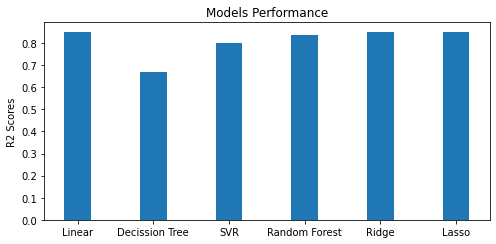

In [34]:
import matplotlib.pyplot as plt

score = [r_sq, dt_sq, svr_sq, rfr_sq, rcv_sq, lcv_sq]
model_name = ["Linear", "Decission Tree", "SVR", "Random Forest", "Ridge", "Lasso"]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

x_range = np.arange(len(model_name))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x_range, score, width)

ax.set_ylabel('R2 Scores')
ax.set_title('Models Performance')
ax.set_xticks(x_range)
ax.set_xticklabels(model_name)

plt.show()

# Best Model (Ridge) Save

In [35]:
import pickle

pkl_filename = "model.pkl"
with open(pkl_filename, "wb") as file:
  pickle.dump(model_r, file)